In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd 
import numpy as np
from tslearn.preprocessing import TimeSeriesResampler
from tslearn.clustering import TimeSeriesKMeans
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sbn 
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import statsmodels.api as sm
from patsy import dmatrices

import sys
sys.path.append('./src/')
%aimport lib

In [2]:
class EFM_neratinib: 
    def __init__(self): 
        self.load = ['normalized']
        self.data = ['./data/HER2_EFM192A_data_11-1-21/']
        self.drug = ['neratinib']
        self.resample_sz = [125]
        self.nclus = [10]
        self.sensitive_line = ['WT']
        self.resistant_line = ['T798I']
        self.burnin = [2]
        self.batch_correct = [True]

class EFM_trastuzumab: 
    def __init__(self): 
        self.load = ['normalized']
        self.data = ['./data/HER2_EFM192A_data_11-1-21/']
        self.drug = ['trastuzumab']
        self.resample_sz = [100]
        self.nclus = [15]
        self.sensitive_line = ['WT']
        self.resistant_line = ['ND611']
        self.burnin = [2]
        self.batch_correct = [True]

class SKB_neratinib: 
    def __init__(self): 
        self.load = ['normalized']
        self.data = ['./data/HER2_SKBR3_data_6-7-21/']
        self.drug = ['neratinib']
        self.resample_sz = [100]
        self.nclus = [15]
        self.sensitive_line = ['WT']
        self.resistant_line = ['T798I']
        self.burnin = [0]
        self.batch_correct = [True]

class SKB_trastuzumab: 
    def __init__(self): 
        self.load = ['normalized']
        self.data = ['./data/HER2_SKBR3_data_6-7-21/']
        self.drug = ['trastuzumab']
        self.resample_sz = [125]
        self.nclus = [10]
        self.sensitive_line = ['WT']
        self.resistant_line = ['ND611']
        self.burnin = [2]
        self.batch_correct = [True]


In [3]:
## USE this to choose the experiment arguments - modify cell above to change

args = SKB_neratinib()

#args = SKB_trastuzumab()
#args = EFM_neratinib()
#args = EFM_trastuzumab()

In [4]:
data, clover_sel, mscarl_sel = lib.load_data(args)
data.head()


loading data...
# of datasets to load: 13


,track_index,0_x,15_x,30_x,45_x,60_x,75_x,90_x,105_x,120_x,...,2805_y,2820_y,2835_y,2850_y,2865_y,2880_y,2895_y,drug,cell_line,mutant
0,79_1000188375_skbr3_erk_akt__wt_untreated,0.240343,0.305148,0.359093,0.377887,0.430450,0.472083,0.470617,0.594090,0.594985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
1,3_1000012495_skbr3_erk_akt__wt_untreated,0.258892,0.323697,0.405762,0.422704,0.424451,0.429620,0.416867,0.365984,0.361178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
2,79_1000188229_skbr3_erk_akt__wt_untreated,0.360215,0.425021,0.478966,0.501633,0.601752,0.611347,0.571254,0.543516,0.737053,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
3,1_1000003862_skbr3_erk_akt__wt_untreated,0.724460,0.693145,0.805601,0.818410,0.727231,0.674704,0.707653,0.679908,0.713188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
4,3_1000012346_skbr3_erk_akt__wt_untreated,0.526140,0.678670,0.609742,0.562597,0.607743,0.511163,0.552604,0.780575,0.673951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT


In [5]:
data, clover_sel, mscarl_sel = lib.filter_data(args, data, clover_sel, mscarl_sel)


filtering to drug and removing NAs...
drug id: neratinib
Data shape (untreated + drug): (23672, 398)
length of time series BEFORE removing time points with NA 150
length of time series AFTER removing time points with NA 135


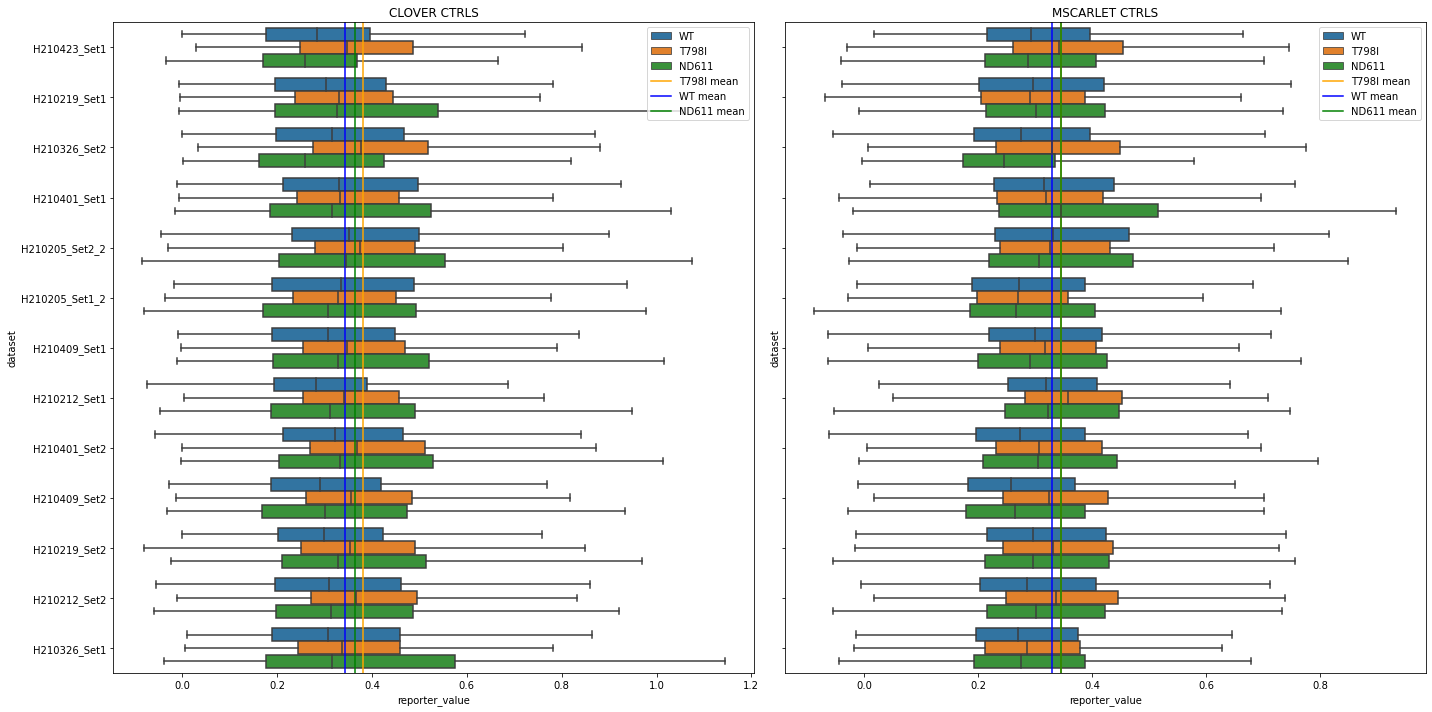

In [6]:
data_ctrls = lib.plot_reporter_batch_effects(data, args, clover_sel, mscarl_sel, save=None)

# BURN IN

In [8]:
# add burnin 
clover_sel = clover_sel[args.burnin[0]:]
mscarl_sel = mscarl_sel[args.burnin[0]:]

In [9]:
X_train = lib.resample(args, data, clover_sel, mscarl_sel)



resampling time series...
Training data shape BEFORE resampling: (23672, 135, 2)
Training data shape AFTER resampling: (23672, 100, 2)



performing time-series kmeans clustering...

4.253 --> 3.101 --> 3.045 --> 3.025 --> 3.013 --> 3.006 --> 3.001 --> 2.998 --> 2.995 --> 2.993 --> 2.991 --> 2.989 --> 2.988 --> 2.987 --> 2.986 --> 2.984 --> 2.983 --> 2.982 --> 2.981 --> 2.981 --> 2.980 --> 2.979 --> 2.979 --> 2.978 --> 2.978 --> 2.977 --> 2.977 --> 2.976 --> 2.976 --> 2.975 --> 2.975 --> 2.974 --> 2.974 --> 2.973 --> 2.973 --> 2.973 --> 2.972 --> 2.972 --> 2.972 --> 2.971 --> 2.971 --> 2.970 --> 2.970 --> 2.970 --> 2.969 --> 2.969 --> 2.968 --> 2.967 --> 2.967 --> 2.966 --> 
plotting...


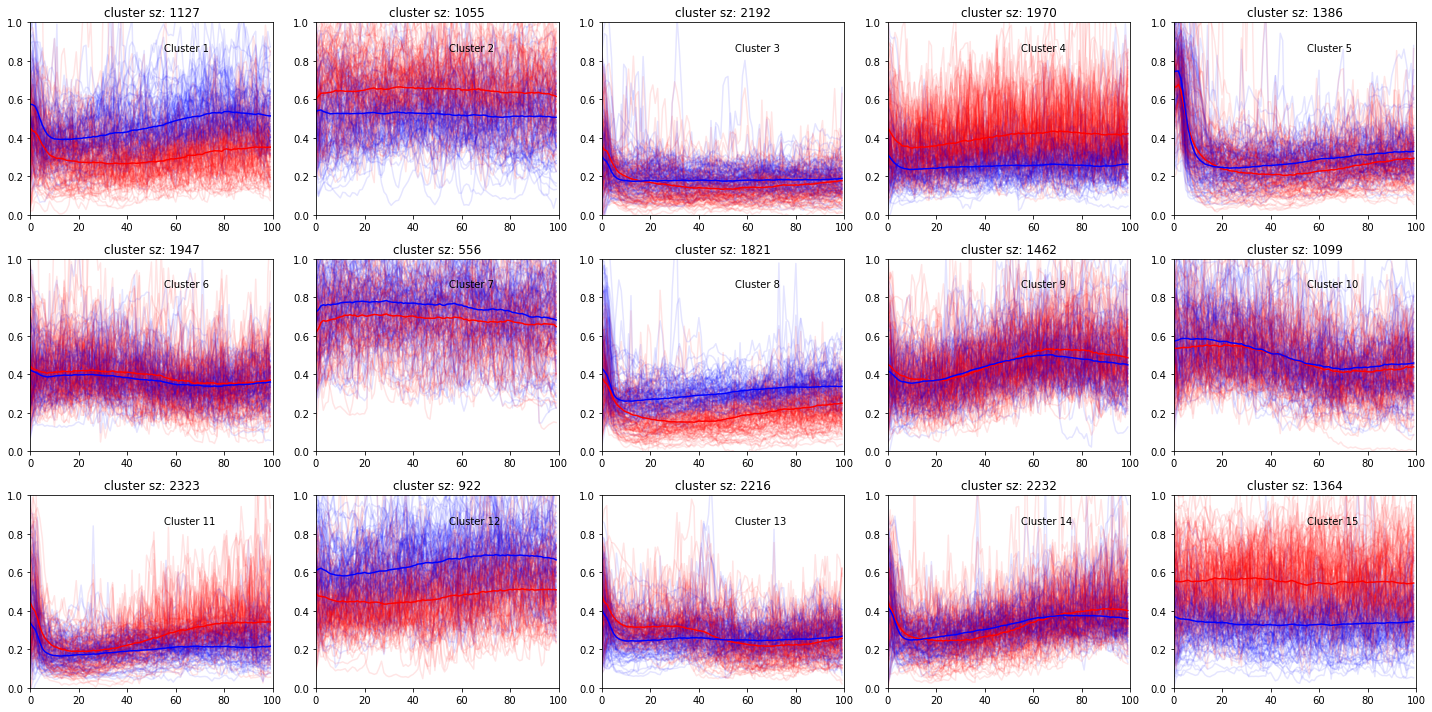

In [10]:
y_pred, km = lib.fit_kmeans(args, X_train, save=None)

In [11]:
cm, lb = lib.calc_cluster_proportions(args, y_pred, data)


quantifying experiment by cluster proportions...


<Figure size 504x504 with 0 Axes>

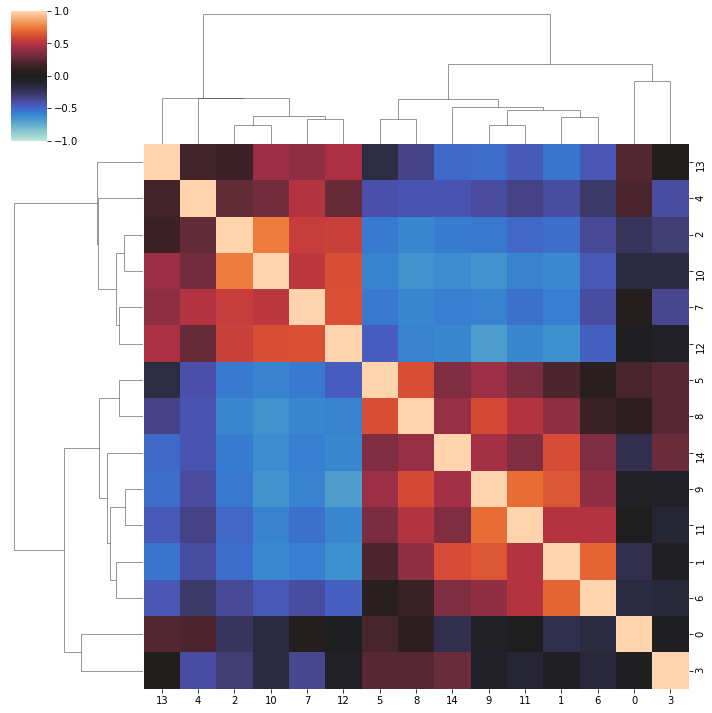

In [12]:
lib.plot_cluster_corr(cm, save=None)


performing dim. reduction (pca)...
PCA explained variance ratio: [0.49618322 0.12004774]
PC shape: (252, 2)


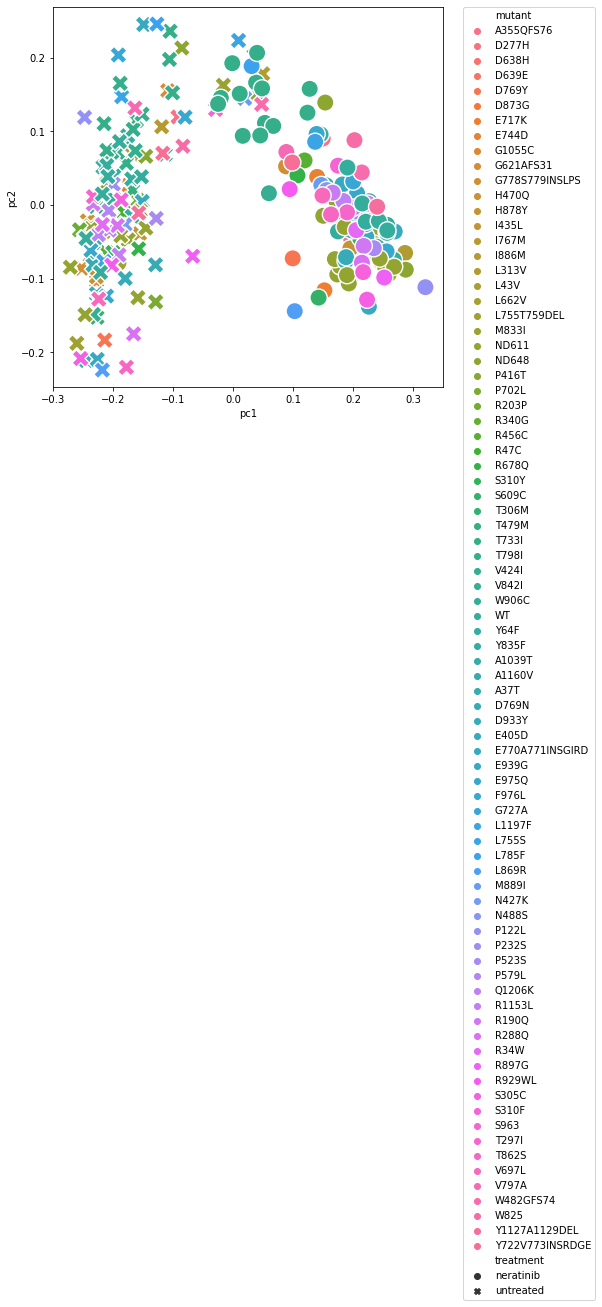

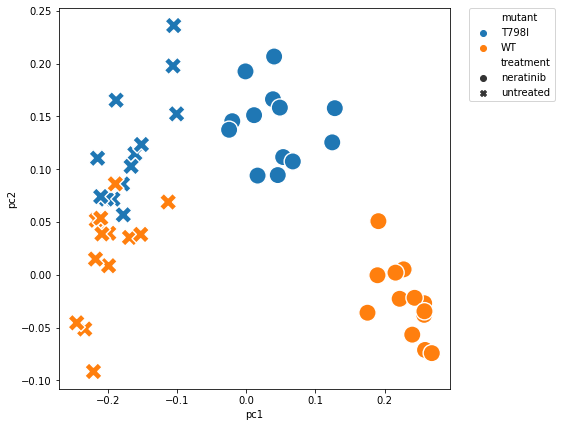

In [34]:
pca, res, _sens, _res, _drug = lib.dimensionality_reduction(args, cm, lb, save=None)

# Add the `cell counts`

In [35]:
cell_cnts = data.groupby(['mutant', 'drug', 'dataset'])['track_index'].count().reset_index().rename({'track_index':'cell_count'}, axis=1).assign(dataset=lambda x: x.dataset.str.upper())
cell_cnts

,mutant,drug,dataset,cell_count
0,A1039T,neratinib,H210326_SET2,125
1,A1039T,untreated,H210326_SET2,96
2,A1160V,neratinib,H210409_SET1,109
3,A1160V,untreated,H210409_SET1,68
4,A355QFS76,neratinib,H210205_SET2_2,134
...,...,...,...,...
247,Y64F,untreated,H210219_SET1,144
248,Y722V773INSRDGE,neratinib,H210401_SET1,58
249,Y722V773INSRDGE,untreated,H210401_SET1,60
250,Y835F,neratinib,H210205_SET2_2,126


In [36]:
res

,pc1,pc2,treatment,mutant,batch
0,0.149673,0.090137,neratinib,A355QFS76,H210205_SET2_2
1,-0.091466,0.119522,untreated,A355QFS76,H210205_SET2_2
2,0.197061,-0.046303,neratinib,D277H,H210219_SET1
3,-0.226161,-0.040319,untreated,D277H,H210219_SET1
4,0.214062,-0.075428,neratinib,D638H,H210219_SET1
...,...,...,...,...,...
247,-0.152260,0.038258,untreated,WT,H210423_SET1
248,0.240369,-0.002380,neratinib,Y1127A1129DEL,H210401_SET2
249,-0.156778,-0.010856,untreated,Y1127A1129DEL,H210401_SET2
250,0.098867,0.057779,neratinib,Y722V773INSRDGE,H210401_SET1


In [37]:
res2 = res.merge(cell_cnts, left_on=['mutant', 'treatment', 'batch'], right_on=['mutant', 'drug', 'dataset'], how='left', validate='1:1').drop(['drug', 'dataset'], axis=1)
res2

,pc1,pc2,treatment,mutant,batch,cell_count
0,0.149673,0.090137,neratinib,A355QFS76,H210205_SET2_2,134
1,-0.091466,0.119522,untreated,A355QFS76,H210205_SET2_2,87
2,0.197061,-0.046303,neratinib,D277H,H210219_SET1,309
3,-0.226161,-0.040319,untreated,D277H,H210219_SET1,179
4,0.214062,-0.075428,neratinib,D638H,H210219_SET1,173
...,...,...,...,...,...,...
247,-0.152260,0.038258,untreated,WT,H210423_SET1,63
248,0.240369,-0.002380,neratinib,Y1127A1129DEL,H210401_SET2,116
249,-0.156778,-0.010856,untreated,Y1127A1129DEL,H210401_SET2,88
250,0.098867,0.057779,neratinib,Y722V773INSRDGE,H210401_SET1,58


In [49]:
res2.groupby(['mutant', 'treatment'])['batch'].unique().reset_index().assign(n_uniq = lambda y: [len(x) for x in y.batch]).sort_values('n_uniq').tail(20)

,mutant,treatment,batch,n_uniq
7,A37T,untreated,"[H210409_SET2, H210423_SET1]",2
21,D933Y,untreated,"[H210409_SET2, H210423_SET1]",2
91,P579L,untreated,"[H210409_SET2, H210423_SET1]",2
35,F976L,untreated,"[H210409_SET2, H210423_SET1]",2
34,F976L,neratinib,"[H210409_SET2, H210423_SET1]",2
103,R288Q,untreated,"[H210409_SET2, H210423_SET1]",2
102,R288Q,neratinib,"[H210409_SET2, H210423_SET1]",2
90,P579L,neratinib,"[H210409_SET2, H210423_SET1]",2
23,E405D,untreated,"[H210409_SET2, H210423_SET1]",2
81,ND648,untreated,"[H210205_SET2_2, H210205_SET1_2]",2


In [44]:
cell_cnts = data.groupby(['mutant', 'drug', 'cell_line'])['track_index'].count().reset_index().rename({'track_index':'cell_count'}, axis=1)
cell_cnts

,mutant,drug,cell_line,cell_count
0,A1039T,neratinib,SKBR3,125
1,A1039T,untreated,SKBR3,96
2,A1160V,neratinib,SKBR3,109
3,A1160V,untreated,SKBR3,68
4,A355QFS76,neratinib,SKBR3,134
...,...,...,...,...
159,Y64F,untreated,SKBR3,144
160,Y722V773INSRDGE,neratinib,SKBR3,58
161,Y722V773INSRDGE,untreated,SKBR3,60
162,Y835F,neratinib,SKBR3,126


In [25]:
res

,pc1,pc2,treatment,mutant,batch,cell_count
0,0.149673,0.090137,neratinib,A355QFS76,H210205_SET2_2,134
1,-0.091466,0.119522,untreated,A355QFS76,H210205_SET2_2,87
2,0.197061,-0.046303,neratinib,D277H,H210219_SET1,309
3,-0.226161,-0.040319,untreated,D277H,H210219_SET1,179
4,0.214062,-0.075428,neratinib,D638H,H210219_SET1,173
...,...,...,...,...,...,...
247,-0.152260,0.038258,untreated,WT,H210423_SET1,63
248,0.240369,-0.002380,neratinib,Y1127A1129DEL,H210401_SET2,116
249,-0.156778,-0.010856,untreated,Y1127A1129DEL,H210401_SET2,88
250,0.098867,0.057779,neratinib,Y722V773INSRDGE,H210401_SET1,58


In [24]:
res = res.merge(cell_cnts, left_on=['mutant', 'treatment', 'cell_line'], right_on=['mutant', 'drug', 'cell_line'], how='left', validate='1:1').drop(['drug'], axis=1)

KeyError: 'cell_line'

# Visualize batch effects 

(then we'll check and correct)

In [15]:
plt.figure(figsize=(5, 10)) 
sbn.boxplot(y='batch', x='pc1_uncor', data=res[lambda x: (x.mutant.isin([args.resistant_line[0], args.sensitive_line[0]]))])
plt.show()

ValueError: Could not interpret input 'pc1_uncor'

<Figure size 360x720 with 0 Axes>

# Test for batch effects 

We do this by running a regression based on batch (filtered to controls). 

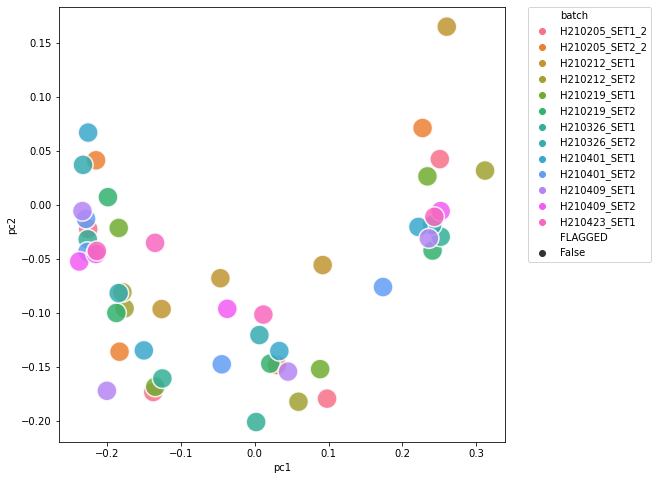

,batch,pc1_coef,pc1_pval,pc2_coef,pc2_pval,run_id
0,H210205_SET1_2,0.019259,0.847684,-0.023356,0.577394,dummy_id
1,H210205_SET2_2,-0.012299,0.902361,0.016882,0.686850,dummy_id
2,H210212_SET1,0.067669,0.500909,0.046071,0.274473,dummy_id
3,H210212_SET2,0.026758,0.789621,-0.022008,0.599463,dummy_id
4,H210219_SET1,0.023713,0.813072,-0.019061,0.649073,dummy_id


In [ ]:
batch_res = lib.get_batch_effects(args, res, 'dummy_id', save=None)
batch_res.head()

# Batch Correction 

Subtract the regression coeficient for each batch (e.g., PCx controls mean by batch) from mutant PCx values. 

In [ ]:
if args.batch_correct[0]: 
    res = lib.batch_correction(res, batch_res)
    res2 = res.assign(pc1_uncor=None, pc2_uncor=None)
else: 
    res = res.assign(pc1_uncor=None, pc2_uncor=None)
    res2 = res

In [ ]:
res

,pc1,pc2,treatment,mutant,batch,cell_count,pc1_coef,pc1_pval,pc2_coef,pc2_pval,run_id,pc1_uncor,pc2_uncor
0,0.224431,-0.068294,neratinib,A355QFS76,H210205_SET2_2,134,-0.012299,0.902361,0.016882,0.686850,dummy_id,0.212132,-0.051413
1,-0.054148,-0.116865,untreated,A355QFS76,H210205_SET2_2,87,-0.012299,0.902361,0.016882,0.686850,dummy_id,-0.066447,-0.099984
2,0.230821,0.019712,neratinib,D639E,H210205_SET2_2,180,-0.012299,0.902361,0.016882,0.686850,dummy_id,0.218522,0.036594
3,-0.203065,0.003779,untreated,D639E,H210205_SET2_2,104,-0.012299,0.902361,0.016882,0.686850,dummy_id,-0.215364,0.020660
4,0.225541,0.022501,neratinib,ND611,H210205_SET2_2,75,-0.012299,0.902361,0.016882,0.686850,dummy_id,0.213242,0.039383
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,-0.175527,-0.109787,untreated,V797A,H210401_SET1,94,-0.007318,0.941809,0.003926,0.925222,dummy_id,-0.182844,-0.105860
248,0.228961,-0.024197,neratinib,WT,H210401_SET1,104,-0.007318,0.941809,0.003926,0.925222,dummy_id,0.221644,-0.020271
249,-0.217881,0.063241,untreated,WT,H210401_SET1,80,-0.007318,0.941809,0.003926,0.925222,dummy_id,-0.225199,0.067168
250,0.107548,-0.104113,neratinib,Y722V773INSRDGE,H210401_SET1,58,-0.007318,0.941809,0.003926,0.925222,dummy_id,0.100231,-0.100186


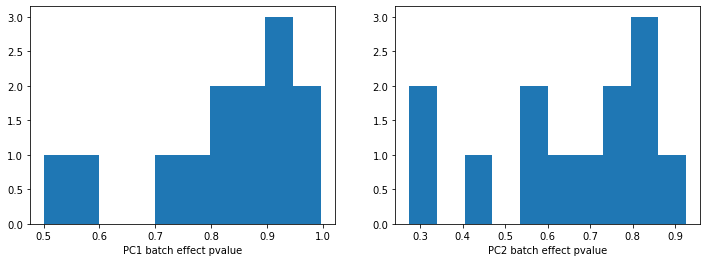

In [ ]:
f,axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(batch_res.pc1_pval, bins=10)
axes[0].set_xlabel('PC1 batch effect pvalue')
axes[1].hist(batch_res.pc2_pval, bins=10)
axes[1].set_xlabel('PC2 batch effect pvalue')
plt.show()

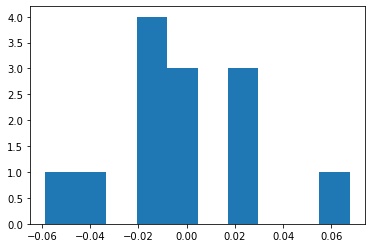

In [ ]:
# batch effect sizes 
plt.figure() 
plt.hist(batch_res.pc1_coef)
plt.show()

# Finally, train classifier - predict mutant resistance/sensitivity


training classifier...
sensitive line: WT
resistant line: T798I
drug: neratinib
drug + WT df size:  (26, 13)
X train shape: (26, 2)
# neg class (resistant): 13
# pos class (sensitive): 13


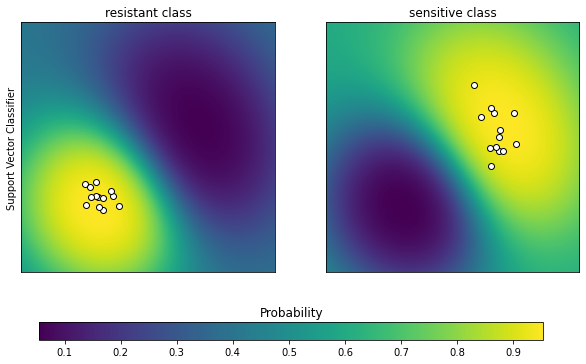

In [ ]:
model, accuracy = lib.train_classifier(res, _sens, _res, _drug, save=None)

In [ ]:
prob_res = lib.predict_new(args, res, model)
prob_res.head()


predicting unlabeled sensitivities...


,pc1,pc2,treatment,mutant,batch,cell_count,pc1_coef,pc1_pval,pc2_coef,pc2_pval,run_id,pc1_uncor,pc2_uncor,prob_res,prob_sens,call
0,0.224431,-0.068294,neratinib,A355QFS76,H210205_SET2_2,134,-0.012299,0.902361,0.016882,0.68685,dummy_id,0.212132,-0.051413,0.127947,0.872053,sens
1,0.230821,0.019712,neratinib,D639E,H210205_SET2_2,180,-0.012299,0.902361,0.016882,0.68685,dummy_id,0.218522,0.036594,0.053830,0.946170,sens
2,0.225541,0.022501,neratinib,ND611,H210205_SET2_2,75,-0.012299,0.902361,0.016882,0.68685,dummy_id,0.213242,0.039383,0.055517,0.944483,sens
3,0.230680,-0.121174,neratinib,ND648,H210205_SET2_2,66,-0.012299,0.902361,0.016882,0.68685,dummy_id,0.218381,-0.104292,0.222904,0.777096,sens
4,0.139730,-0.014698,neratinib,R678Q,H210205_SET2_2,274,-0.012299,0.902361,0.016882,0.68685,dummy_id,0.127431,0.002184,0.285403,0.714597,sens


In [ ]:
prob_res.sort_values('prob_res', ascending=False).head()

,pc1,pc2,treatment,mutant,batch,cell_count,pc1_coef,pc1_pval,pc2_coef,pc2_pval,run_id,pc1_uncor,pc2_uncor,prob_res,prob_sens,call
56,0.032593,-0.160216,neratinib,T798I,H210212_SET2,76,0.026758,0.789621,-0.022008,0.599463,dummy_id,0.059351,-0.182224,0.945207,0.054793,res
5,0.042435,-0.165109,neratinib,T798I,H210205_SET2_2,141,-0.012299,0.902361,0.016882,0.686850,dummy_id,0.030136,-0.148228,0.943878,0.056122,res
114,0.003608,-0.155029,neratinib,T798I,H210326_SET1,84,-0.001484,0.988193,-0.045999,0.275211,dummy_id,0.002125,-0.201028,0.942217,0.057783,res
104,0.014154,-0.137305,neratinib,T798I,H210401_SET2,94,-0.058560,0.559966,-0.010227,0.806942,dummy_id,-0.044406,-0.147531,0.941767,0.058233,res
36,0.029397,-0.136171,neratinib,T798I,H210219_SET2,86,-0.008222,0.934633,-0.010751,0.797266,dummy_id,0.021175,-0.146922,0.941356,0.058644,res


# How does batch effect correction change our results? 


In [ ]:
prob_res_uncor = lib.predict_new(args, res2, model)
prob_res_uncor.head()


predicting unlabeled sensitivities...


,pc1,pc2,treatment,mutant,batch,cell_count,pc1_coef,pc1_pval,pc2_coef,pc2_pval,run_id,pc1_uncor,pc2_uncor,prob_res,prob_sens,call
0,0.224431,-0.068294,neratinib,A355QFS76,H210205_SET2_2,134,-0.012299,0.902361,0.016882,0.68685,dummy_id,None,None,0.127947,0.872053,sens
1,0.230821,0.019712,neratinib,D639E,H210205_SET2_2,180,-0.012299,0.902361,0.016882,0.68685,dummy_id,None,None,0.053830,0.946170,sens
2,0.225541,0.022501,neratinib,ND611,H210205_SET2_2,75,-0.012299,0.902361,0.016882,0.68685,dummy_id,None,None,0.055517,0.944483,sens
3,0.230680,-0.121174,neratinib,ND648,H210205_SET2_2,66,-0.012299,0.902361,0.016882,0.68685,dummy_id,None,None,0.222904,0.777096,sens
4,0.139730,-0.014698,neratinib,R678Q,H210205_SET2_2,274,-0.012299,0.902361,0.016882,0.68685,dummy_id,None,None,0.285403,0.714597,sens


In [ ]:
comp = prob_res[['mutant', 'prob_res']].merge(prob_res_uncor[['mutant', 'prob_res']], on='mutant').assign(delta=lambda x: x.prob_res_x - x.prob_res_y)
comp.head()

,mutant,prob_res_x,prob_res_y,delta
0,A355QFS76,0.127947,0.127947,0.000000
1,D639E,0.053830,0.053830,0.000000
2,ND611,0.055517,0.055517,0.000000
3,ND611,0.055517,0.128812,-0.073295
4,ND611,0.055517,0.094487,-0.038970


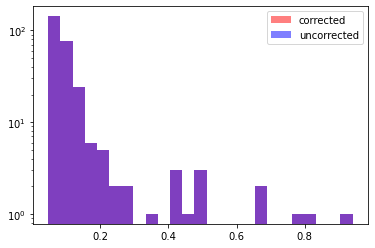

In [ ]:
plt.figure()
plt.hist(comp[lambda x: ~(x.mutant.isin([args.sensitive_line[0], args.resistant_line[0]]))].prob_res_x, color='r', alpha=0.5, bins=25, label='corrected')
plt.hist(comp[lambda x: ~(x.mutant.isin([args.sensitive_line[0], args.resistant_line[0]]))].prob_res_y, color='b', alpha=0.5, bins=25, label='uncorrected')
plt.yscale('log')
plt.legend()
plt.show()

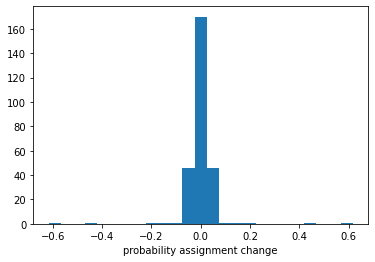

In [ ]:
plt.figure()
plt.hist(comp[lambda x: ~(x.mutant.isin([args.sensitive_line[0], args.resistant_line[0]]))].delta, bins=25)
plt.xlabel('probability assignment change')
plt.show()

In [ ]:
# mutants with the most change
comp[lambda x: ~(x.mutant.isin([args.sensitive_line[0], args.resistant_line[0]]))].sort_values('delta', ascending=False)

,mutant,prob_res_x,prob_res_y,delta
580,L755S,0.668342,0.051117,0.617225
576,F976L,0.505646,0.049156,0.456490
172,ND648,0.222904,0.047559,0.175345
564,A37T,0.208349,0.065252,0.143097
23,ND611,0.128812,0.054061,0.074750
...,...,...,...,...
107,ND611,0.054061,0.128812,-0.074750
565,A37T,0.065252,0.208349,-0.143097
173,ND648,0.047559,0.222904,-0.175345
577,F976L,0.049156,0.505646,-0.456490


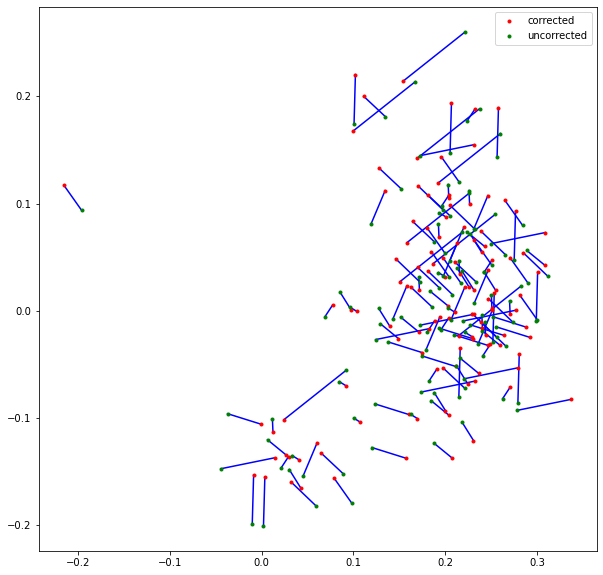

In [ ]:
# how does batch effect correction change our results?

plt.figure(figsize=(10,10))
for i,row in prob_res.iterrows(): 
    plt.plot(row[['pc1_uncor', 'pc1']].values, row[['pc2_uncor', 'pc2']].values, 'b-')

plt.plot(prob_res['pc1'].values,prob_res['pc2'].values, 'r.', label='corrected')
plt.plot(prob_res['pc1_uncor'].values,prob_res['pc2_uncor'].values, 'g.', label='uncorrected')
plt.legend()
plt.show()